# VAE Example in Pytorch
## STAT 940

### Introduction

In this tutorial we will train a simple Variational Autoencoder in following five steps:
- Step 1)  Import libraries and set parameters
- Step 2) Load and prepare data
- Step 3) Model Definition
- Step 4) Set up optimizers and loss functions
- Step 5) Learning model and fit it on training data

Also we will see how to:
- Save and load learned models
- Predit labels of test data
- Check accuracy of model

### STEP 1 - Import libraries and set parameters

First, we will import the necessary libraries and packages that are needed for VAE.
- 1) Numpy: NumPy is the fundamental package for scientific computing with Python
- 2) torch, torch.nn, torch.nn.functional, torch.optim: Pytorch imports for building custom neural networks containing
    - Sequential model type: This provides linear stack of neural network layers and it is useful in MLP and CNN nets.
    - Core layers (Linear, Dropout, ReLU): these layers are used in most neural networks
    - Convolutional, ConvTranspose
    - data tools: DataSet for custom data sets, DataLoader for loading in data
    - optim: optimizers
- 3) torchvision: Vision specific Pytorch. Provides useful augmentations, datasets, pretrained models
- 4) matplotlib.pyplot: for plotting figures and images

In [1]:
# 1)
import numpy as np
# 2)
import torch     
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
# 3)
import torchvision
# 4)
import matplotlib.pyplot as plt

In [2]:
np.random.seed(940) # set seed for reproducibility (within numpy)
torch.manual_seed(940) # set seed for reproducibility (within pytorch)

#### Parameters

In [3]:
batch_size = 32      #batch size
epochs = 100        #epoch size

#### Set-up GPU (optional)

Leverage GPUs for faster training of neural networks. This section will help you set up GPUs on Pytorch

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # check is GPU is available
print(device)

cuda:0


### STEP 2 - Load and prepare data

In [5]:
train = torchvision.datasets.FashionMNIST("./", train=True, download=True)
test = torchvision.datasets.FashionMNIST("./", train=False, download=True)

print('# train:', len(train))
print("# test:", len(test))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw

# train: 60000
# test: 10000


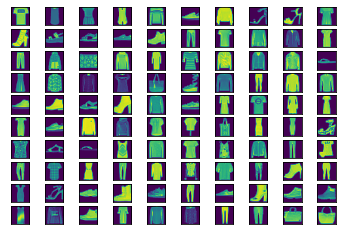

In [6]:
# show some images
plt.figure()                                      # create new figure
fig_size = [20, 20]                               # specify figure size
plt.rcParams["figure.figsize"] = fig_size         # set figure size

#Plot firs 100 train image of dataset
for i in range(1,101):                          
    ax = plt.subplot(10, 10, i)                   # Specify the i'th subplot of a 10*10 grid
    img = train[i][0]                             # train[i][0] is the image, train[i][1] is the label
    ax.get_xaxis().set_visible(False)             # Disable plot axis.
    ax.get_yaxis().set_visible(False)
    plt.imshow(img)
    
plt.show()

#### Prepare Data

In [7]:
# transforms
# first convert image to tensor with values in [0, 1]
# normalize image over all channels to be between [-1, 1]

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# attach transforms to dataset
train = torchvision.datasets.FashionMNIST("./", train=True, transform=transform, download=True)
test = torchvision.datasets.FashionMNIST("./", train=False, transform=transform, download=True)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True) # shuffle training examples
test_loader = DataLoader(test, batch_size=1, shuffle=False) # don't shuffle test set

### STEP 3 - Model Definition
Here, we will define a very simple Variational Autoencoder. It consists of an encoder network and a decoder network. The encoder network consists of 3 convolutional layers with ReLU activation.

We represent mu, sigma parameters as two fully connected layers with size equal to the hidden dimension.

The decoder layer consists of 3 convtranspose layers with ReLU activation.

We set the hidden dimension to 10

In [8]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        # encoder
        self.encoder = nn.Sequential(
                nn.Conv2d(1, 32, 4, 1, 2),   # B,  32, 28, 28
                nn.ReLU(),
                nn.Conv2d(32, 32, 4, 2, 1),  # B,  32, 14, 14
                nn.ReLU(),
                nn.Conv2d(32, 64, 4, 2, 1), # B,  64,  7, 7
                nn.ReLU()  
            )

        # parameters of mu, log_sigma (to avoid negative variance)
        self.mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.log_sigma = nn.Linear(64 * 7 * 7, latent_dim)
        
        # decoder
        self.fc = nn.Linear(latent_dim, 64 * 7 * 7)

        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # B,  64,  14,  14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 4, 2, 1, 1), # B,  32, 28, 28
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 1, 2)   # B, 1, 28, 28
        )

    def reparameterize(self, mu, log_sigma):

        sigma = torch.exp(log_sigma / 2)
        e = torch.randn_like(sigma)
        return mu + sigma * e

    def forward(self, x, train=True):

        # encoding
        x = self.encoder(x)

        # get latent variables
        x = torch.flatten(x, 1) 
        mu = self.mu(x)
        log_sigma = self.log_sigma(x)

        if train:
            x = self.reparameterize(mu, log_sigma)
        else:
            x = self.reparameterize(mu, torch.zeros_like(mu))

        # convert latent representation for conv transpose
        x = self.fc(x)
        x = x.view(-1, 64, 7, 7)

        # decoder
        x = self.decoder(x)
        # all 3 tensors are needed for loss computation
        return x, mu, log_sigma

In [9]:
net = VAE(10)

# test out on one batch of images - each batch is given as a list of [Images, Labels]
batch = next(iter(train_loader))
images = batch[0]
labels = batch[1]

print("Batch shape (image): ", images.shape)
print("Batch shape (label): ", labels.shape)

# feed batch to model
x, mu, log_sigma = net(images)
print("Output shape:", x.shape)

Batch shape (image):  torch.Size([32, 1, 28, 28])
Batch shape (label):  torch.Size([32])
Output shape: torch.Size([32, 1, 28, 28])


In [10]:
# model summary (without logging)
net = VAE(10)
net = net.to(device) # move model to GPU
print(net)

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (mu): Linear(in_features=3136, out_features=10, bias=True)
  (log_sigma): Linear(in_features=3136, out_features=10, bias=True)
  (fc): Linear(in_features=10, out_features=3136, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  )
)


### STEP 4 - Set up optimizers and loss functions

In [11]:
optimizer = optim.Adam(net.parameters(), lr=1e-4) # Adam as optimizer

#### Training Loop

In [12]:
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # move the data to GPU
        inputs = inputs.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output, mu, log_sigma = net(inputs)

        # kl divergence
        kl_divergence = (0.5 * torch.sum(-1 - log_sigma + mu.pow(2) + log_sigma.exp())).sum()
        # final loss is KL divergence + reconstruction error
        loss = F.mse_loss(output, inputs, reduction="sum") + kl_divergence
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print(f'[{epoch + 1}] loss: {running_loss / len(train_loader.dataset):.3f}')

print('Finished Training')

[1] loss: 39.999
[2] loss: 29.800
[3] loss: 28.368
[4] loss: 27.612
[5] loss: 27.103
[6] loss: 26.726
[7] loss: 26.430
[8] loss: 26.200
[9] loss: 25.986
[10] loss: 25.811
[11] loss: 25.662
[12] loss: 25.512
[13] loss: 25.402
[14] loss: 25.266
[15] loss: 25.199
[16] loss: 25.131
[17] loss: 25.023
[18] loss: 24.967
[19] loss: 24.873
[20] loss: 24.817
[21] loss: 24.779
[22] loss: 24.736
[23] loss: 24.674
[24] loss: 24.613
[25] loss: 24.584
[26] loss: 24.532
[27] loss: 24.497
[28] loss: 24.462
[29] loss: 24.430
[30] loss: 24.393
[31] loss: 24.341
[32] loss: 24.346
[33] loss: 24.300
[34] loss: 24.254
[35] loss: 24.239
[36] loss: 24.228
[37] loss: 24.192
[38] loss: 24.159
[39] loss: 24.151
[40] loss: 24.116
[41] loss: 24.094
[42] loss: 24.072
[43] loss: 24.065
[44] loss: 24.047
[45] loss: 24.018
[46] loss: 24.016
[47] loss: 23.971
[48] loss: 23.981
[49] loss: 23.946
[50] loss: 23.935
[51] loss: 23.924
[52] loss: 23.891
[53] loss: 23.891
[54] loss: 23.866
[55] loss: 23.848
[56] loss: 23.839
[

### Save the model and load the model

In [13]:
PATH = './vae_net.pth'

torch.save(net.state_dict(), PATH) # save model to path

net = VAE(10) # create new network
net.load_state_dict(torch.load(PATH)) # load the weights of saved model
net = net.to(device) # move network to gpu

### Make a prediction on the test set

The reconstructions aren't the greatest but with more training epochs, the reconstruction should get better.

<PIL.Image.Image image mode=L size=28x28 at 0x7F029C160990>


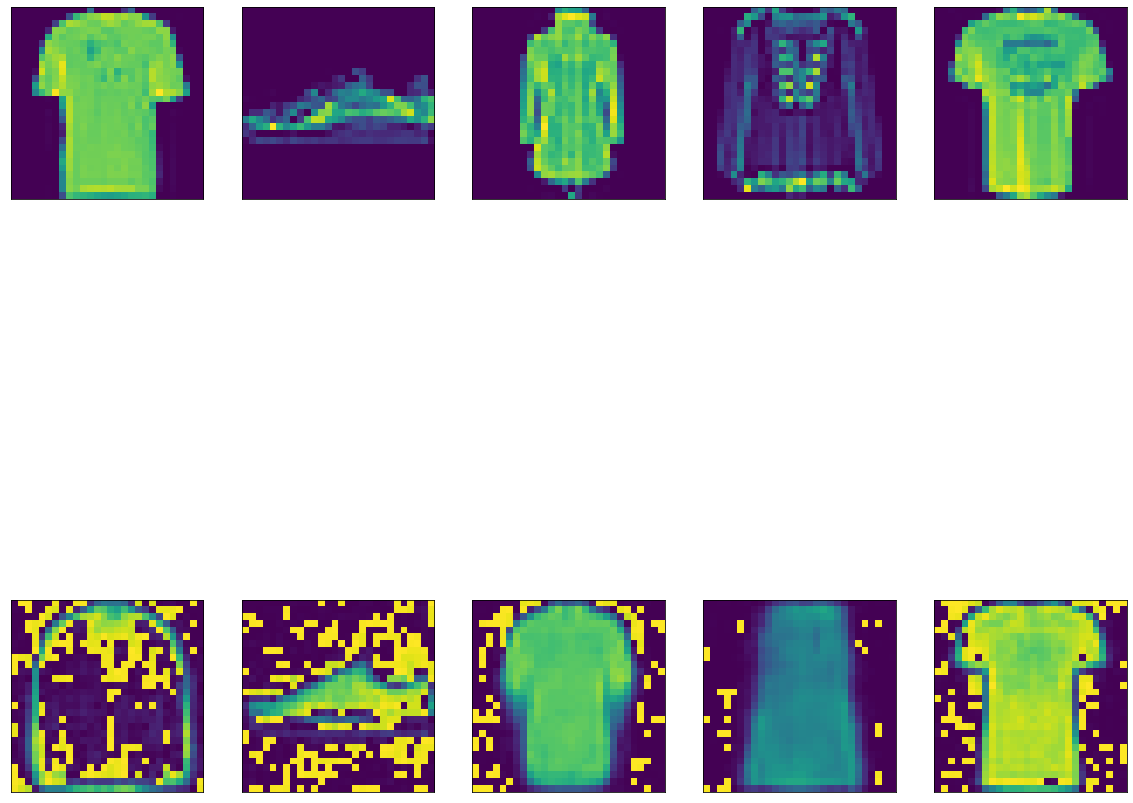

In [24]:
from torchvision.transforms import transforms
train = torchvision.datasets.FashionMNIST("./", train=True, download=True)
test = torchvision.datasets.FashionMNIST("./", train=False, download=True)

plt.figure()                                      # create new figure
fig_size = [20, 20]                               # specify figure size
plt.rcParams["figure.figsize"] = fig_size         # set figure size

with torch.no_grad(): # turns off gradient computation when predicting
    net.eval()
    
    for i in range(1, 6):
        random_index = np.random.randint(10000)
        images = test[random_index][0]
        ax = plt.subplot(2, 5, i)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(images)
        ax = plt.subplot(2, 5, 5+i)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        tensor_image = transform(images,)
        out, mu, log_sigma = net(tensor_image.unsqueeze(0).to(device), train=False)
        predicted_image = transforms.ToPILImage()(out.squeeze(0))
        plt.imshow(predicted_image)


    print(images)


We can also use the decoder part of the network for image generation.

In [45]:
# get necessary layers from original network
fc = net.fc
decoder = net.decoder

def generate_image():
    plt.figure()                                      # create new figure
    fig_size = [20, 20]                               # specify figure size
    plt.rcParams["figure.figsize"] = fig_size         # set figure size

    #Plot firs 100 train image of dataset
    for i in range(1,101):                          
        ax = plt.subplot(10, 10, i)                   # Specify the i'th subplot of a 10*10 grid
        new_latent = torch.randn_like(mu)
        new_data = fc(new_latent)
        new_data = new_data.view(-1, 64, 7, 7)
        new_image = decoder(new_data)
        new_image = transforms.ToPILImage()(new_image.squeeze(0))                             # train[i][0] is the image, train[i][1] is the label
        ax.get_xaxis().set_visible(False)             # Disable plot axis.
        ax.get_yaxis().set_visible(False)
        plt.imshow(new_image)
        
    plt.show()

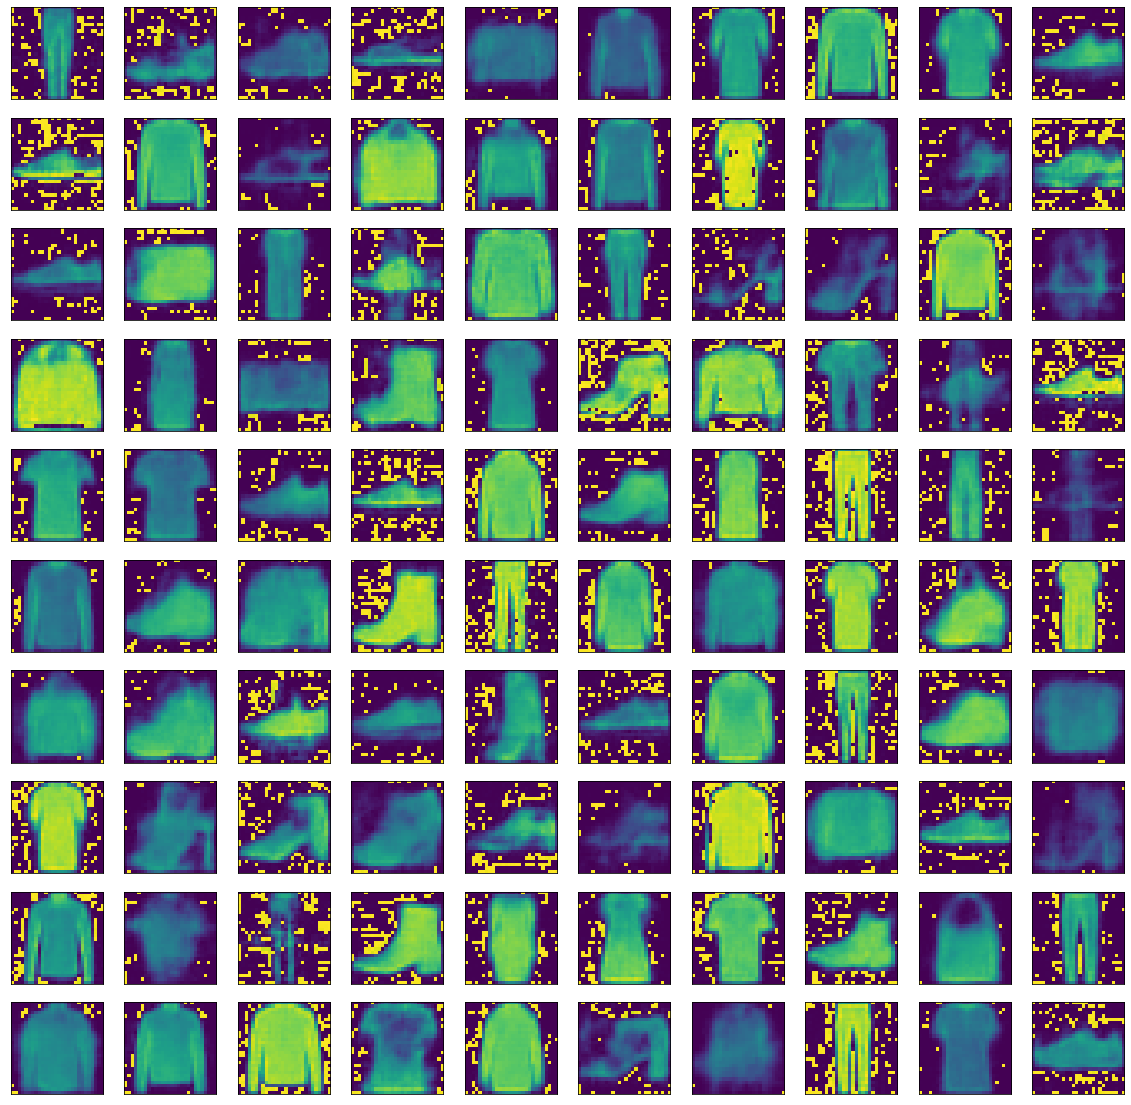

In [46]:
generate_image()